# **Feedback Prize - Evaluating Student Writing**
---------------------------------------------------------------------

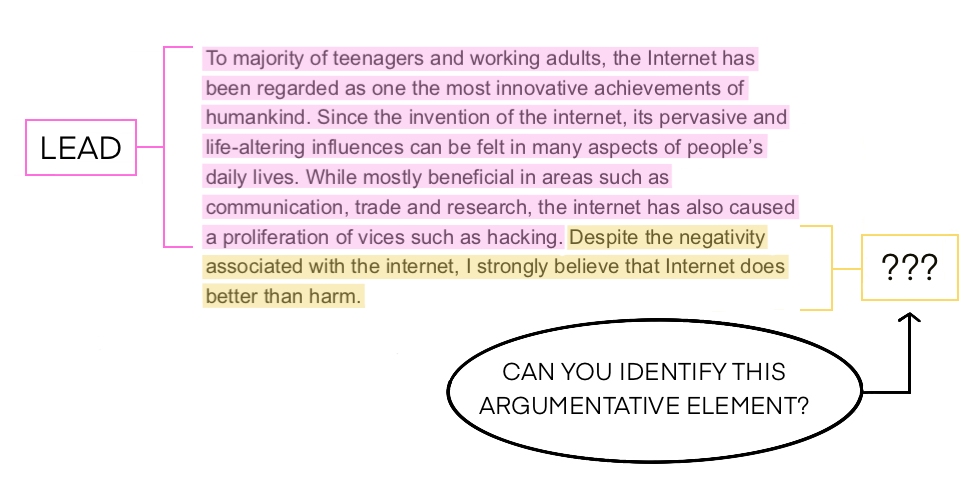

# <center>Problem Statement</center>
------------------------------

### **Identify elements in student writing. More specifically, Automatically segment texts and classify argumentative nd rhetorical elements in essays written by 6th-12th grade students.**

Something like this 👇

In [ ]:
from IPython.display import Image
Image("../input/feedbackimg/feedback.png")

* **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
* **Position** - an opinion or conclusion on the main question
* **Claim** - a claim that supports the position
* **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position
* **Rebuttal** - a claim that refutes a counterclaim
* **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
* **Concluding Statement** - a concluding statement that restates the claims

# <center>Importing Requirements</center>

In [ ]:
!pip install autocorrect 
import os
import numpy as np
import pandas as pd
import wordcloud
import spacy

import tensorflow as tf

from tqdm import tqdm
from glob import glob
from zipfile import ZipFile # File extraction 

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

import transformers
from transformers import AutoModel, AutoTokenizer 

from transformers import BertTokenizer, BertModel,TFAutoModel
from transformers import BertTokenizerFast, BertConfig

from transformers import AutoTokenizer,AutoConfig

# <center>Load Dataset</center>

In [ ]:
train_df = pd.read_csv("../input/feedback-prize-2021/train.csv")


train_dir = "../input/feedback-prize-2021/train"
test_dir = "../input/feedback-prize-2021/test"
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

for file in range(len(train_files)):
    train_files[file] = str(train_dir) + "/" +  str(train_files[file])
for file in range(len(test_files)):
    test_files[file] = str(test_dir) + "/" +  str(test_files[file])
    

train_df = train_df.iloc[:50000,:]
train_txt = glob('../input/feedback-prize-2021/train/*.txt')
print(f"Total number of discourses : {train_df.shape[0]}")

In [ ]:
train_df.head()

# <center>FULL EASSY BY A SINGLE ID.</center>

In [ ]:
def essay(id):
    full_essay = " ".join(train_df[train_df['id'] == id]['discourse_text'])
    return full_essay
essay("423A1CA112E2")

In [ ]:
IDS = train_df.id.unique()

train_df['discourse_len'] = train_df['discourse_text'].apply(lambda x : len(x.split()))
train_df['pred_string_len'] = train_df['predictionstring'].apply(lambda x : len(x.split()))

In [ ]:
print(train_df.query('discourse_len != pred_string_len')['discourse_text'].values[0],"\n\n")
print(train_df.query('discourse_len != pred_string_len')['discourse_text'].values[0].split(),end = " ")
print("\n\n Length of discourse text : ",len(train_df.query('discourse_len != pred_string_len')['predictionstring'].values[0].split()))

# <center>EXPLORATORY DATA ANALYSIS</center>
----

### DISCOURSE TYPE DISTRIBUTION

In [ ]:
df = train_df["discourse_type"].value_counts(ascending=True).reset_index()
fig = px.bar(df,x = 'discourse_type',y = 'index',color ='discourse_type',title = 'DISCOURSE TYPE DISTRIBUTION')
fig.show()

### DISCOURSE TYPE DISTRIBUTION

In [ ]:
dist = train_df.groupby('id')['discourse_type'].apply(lambda x: len(list(x)))
px.histogram(dist,title = 'DISCOURSE TYPE DISTRIBUTION')

### ENUMERATED CLASS LABEL OF DISCOURSE ELEMENT DISTRIBUTION

In [ ]:
df = train_df['discourse_type_num'].value_counts().reset_index()
px.bar(df,x = 'index',y = 'discourse_type_num',color = 'index',
       title = 'ENUMERATED CLASS LABEL OF DISCOURSE ELEMENT DISTRIBUTION')

### DISCOURSE TEXT DISTRIBUTION

In [ ]:
train_df["discourse_len"] = train_df["discourse_end"] - train_df["discourse_start"]
fig = px.histogram(data_frame= train_df,x = "discourse_len",  
                   marginal="violin",nbins = 400,title ='DISCOURSE TEXT DISTRIBUTION',
                  labels = {"discourse_len":'discourse lengnth'})
fig.show()

### WORDCLOUD

In [ ]:
wordcloud_cls = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(' '.join(txt for txt in train_df["discourse_text"]))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_cls, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_cls);

### NUMBER OF DISCOURSE TYPE USED IN ESSAY

In [ ]:
px.pie(df,names = 'index',values = 'discourse_type_num',
       color = 'index',
       title = 'NUMBER OF DISCOURSE TYPE USED IN ESSAY',
       hole = 0.3,
      width = 1000,height = 750)

### FOR EVERY ESSAY, 7 MOST IMPORTANT WORDS

In [ ]:
df = train_df.groupby(by = 'id',
                      as_index = False).agg({"discourse_text": lambda x : " ".join(list(x))})

tfidf = TfidfVectorizer(stop_words='english')
x = tfidf.fit_transform(df['discourse_text'])
feature_names = np.array(tfidf.get_feature_names_out())

TOP_N = 7
def get_top_tf_idf_words(response, top_n=TOP_N):
    sorted_nzs = np.argsort(response.data)[-TOP_N:]
    return feature_names[response.indices[sorted_nzs]]

df['most_imp_words'] = [get_top_tf_idf_words(response,TOP_N) for response in x]
[list(imp) for imp in df['most_imp_words'][0:20]]

### FOR EVERY DISCOURSE TYPE, 7 MOST IMPORTANT WORDS

In [ ]:
df = train_df.groupby(by = 'discourse_type',
                      as_index = False).agg({"discourse_text": lambda x : " ".join(list(x))})

tfidf = TfidfVectorizer(stop_words='english')
x = tfidf.fit_transform(df['discourse_text'])
feature_names = np.array(tfidf.get_feature_names_out())

TOP_N = 7
def get_top_tf_idf_words(response, top_n=TOP_N):
    sorted_nzs = np.argsort(response.data)[-TOP_N:]
    return feature_names[response.indices[sorted_nzs]]

df['discourse_imp_word'] = [get_top_tf_idf_words(response,TOP_N) for response in x]
[list(imp) for imp in df['discourse_imp_word'][0:20]]

### DISCOURSE TYPE NUMBER(discourse_type_num) COUNT

In [ ]:
df = train_df.groupby(by = ['discourse_type','discourse_type_num'],
                 as_index= False).agg({"id":'count'}).rename(columns = {'id':'count'})
px.bar(df,x = 'discourse_type',y = 'count',
       barmode = 'overlay',
       color = 'discourse_type_num',
       text = 'count',
       title = 'DISCOURSE TYPE NUMBER COUNT',labels = {"discourse_type":"discourse type"})

### AVERAGE START AND END POSITION ABSOLUTE

In [ ]:
df= train_df.groupby("discourse_type")[['discourse_end','discourse_start']].mean().reset_index().sort_values(by = 'discourse_start',
                            ascending = False)
df['per'] = [str("%.2f" % i)+str('%') for i in df['discourse_end'].values*100 / df['discourse_end'].values.sum()]

px.bar(df,y = 'discourse_type',x =['discourse_end','discourse_start'],
                            title='AVERAGE START AND END POSIONT ABSOLUTE',
                            height = 800,
                            width = 1200,
                            text = 'per')

Above graph tell us that every essay starts from lead  and lead value will be always small.

# <center>TOKENIZE TRAIN</center>

In [ ]:
MAX_LEN = 1024

# THE TOKENS AND ATTENTION ARRAYS
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
train_tokens = np.zeros((len(IDS),MAX_LEN), dtype='int32')
train_attention = np.zeros((len(IDS),MAX_LEN), dtype='int32')

# THE 14 CLASSES FOR NER
lead_b = np.zeros((len(IDS),MAX_LEN))
lead_i = np.zeros((len(IDS),MAX_LEN))

position_b = np.zeros((len(IDS),MAX_LEN))
position_i = np.zeros((len(IDS),MAX_LEN))

evidence_b = np.zeros((len(IDS),MAX_LEN))
evidence_i = np.zeros((len(IDS),MAX_LEN))

claim_b = np.zeros((len(IDS),MAX_LEN))
claim_i = np.zeros((len(IDS),MAX_LEN))

conclusion_b = np.zeros((len(IDS),MAX_LEN))
conclusion_i = np.zeros((len(IDS),MAX_LEN))

counterclaim_b = np.zeros((len(IDS),MAX_LEN))
counterclaim_i = np.zeros((len(IDS),MAX_LEN))

rebuttal_b = np.zeros((len(IDS),MAX_LEN))
rebuttal_i = np.zeros((len(IDS),MAX_LEN))

# HELPER VARIABLES
train_lens = []
targets_b = [lead_b, position_b, evidence_b, claim_b, conclusion_b, counterclaim_b, rebuttal_b]
targets_i = [lead_i, position_i, evidence_i, claim_i, conclusion_i, counterclaim_i, rebuttal_i]
target_map = {'Lead':0, 'Position':1, 'Evidence':2, 'Claim':3, 'Concluding Statement':4,
             'Counterclaim':5, 'Rebuttal':6}

### HISTOGRAM OF TRAIN TEXT TOKEN COUNT

In [ ]:
from tqdm import tqdm
from autocorrect import Speller

spell = Speller(lang='en')

# FOR LOOP THROUGH EACH TRAIN TEXT
for id_num in tqdm(range(len(IDS))):   
    n = IDS[id_num]
    name = f'../input/feedback-prize-2021/train/{n}.txt'
    txt = open(name, 'r').read()
    txt = spell(txt)
    train_lens.append( len(txt.split()))
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    train_tokens[id_num,] = tokens['input_ids']
    train_attention[id_num,] = tokens['attention_mask']
    
    # FIND TARGETS IN TEXT AND SAVE IN TARGET ARRAYS
    offsets = tokens['offset_mapping']
    offset_index = 0
    df = train_df.loc[train_df.id==n]
    for index,row in df.iterrows():
        a = row.discourse_start
        b = row.discourse_end
        if offset_index>len(offsets)-1:
            break
        c = offsets[offset_index][0]
        d = offsets[offset_index][1]
        beginning = True
        while b>c:
            if (c>=a)&(b>=d):
                k = target_map[row.discourse_type]
                if beginning:
                    targets_b[k][id_num][offset_index] = 1
                    beginning = False
                else:
                    targets_i[k][id_num][offset_index] = 1
            offset_index += 1
            if offset_index>len(offsets)-1:
                break
            c = offsets[offset_index][0]
            d = offsets[offset_index][1]

### HISTOGRAM OF GAP LENGTH (GAPS UPTO 300 CHARACTERS ONLY)

In [ ]:
plt.figure(figsize=(12,5))            
plt.hist(train_lens,bins=100)
plt.title("Histogram of gap length (gaps up to 300 characters only)")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps in characters")
plt.show()

In [ ]:
targets = np.zeros((len(IDS),MAX_LEN,15), dtype='int32')
for k in range(7):
    targets[:,:,2*k] = targets_b[k]
    targets[:,:,2*k+1] = targets_i[k]
targets[:,:,14] = 1-np.max(targets,axis=-1)

In [ ]:
# np.save(f'targets_{MAX_LEN}', targets)
# np.save(f'tokens_{MAX_LEN}', train_tokens)
# np.save(f'attention_{MAX_LEN}', train_attention)
# print('Saved NER tokens')
# targets = np.load(f'targets_{MAX_LEN}.npy')
# train_tokens = np.load(f'tokens_{MAX_LEN}.npy')
# train_attention = np.load(f'attention_{MAX_LEN}.npy')
# print('Loaded NER tokens')

# <center>Modelling</center>
---

In [ ]:
DOWNLOADED_MODEL_PATH = '../input/tflongformerv12'

def build_model():    
    tokens = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(MAX_LEN,), name = 'attention', dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(DOWNLOADED_MODEL_PATH+'/config.json') 
    backbone = TFAutoModel.from_pretrained(DOWNLOADED_MODEL_PATH+'/tf_model.h5', config=config)
    
    x = backbone(tokens, attention_mask=attention)
    x = tf.keras.layers.Dense(256, activation='relu')(x[0])
    x = tf.keras.layers.Dense(15, activation='softmax', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=[tokens,attention], outputs=x)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                  loss = [tf.keras.losses.CategoricalCrossentropy()],
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    
    return model

In [ ]:
model = build_model()

In [ ]:
# TRAIN VALID SPLIT 90% 10%
np.random.seed(42)
train_idx = np.random.choice(np.arange(len(IDS)),int(0.99*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)
np.random.seed(None)
print('Train size',len(train_idx),', Valid size',len(valid_idx))

In [ ]:
# LEARNING RATE SCHEDULE AND MODEL CHECKPOINT
EPOCHS = 5
LRS = np.array([0.125e-4, 0.125e-4, 0.125e-4, 0.125e-4, 0.125e-5])*2
#offline, more memory: [1e-4, 1e-4, 1e-4, 1e-4, 1e-5]
def lrfn(epoch):
    return LRS[epoch]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
model.fit(x = [train_tokens[train_idx,], train_attention[train_idx,]],
      y = targets[train_idx,],
      validation_data = ([train_tokens[valid_idx,], train_attention[valid_idx,]],
                         targets[valid_idx,]),
      callbacks = [lr_callback],
      epochs = EPOCHS,
      batch_size = 4,
      verbose = True)
model.save_weights('long_v_final_model.h5')

In [ ]:
p = model.predict([train_tokens[valid_idx,], train_attention[valid_idx,]], 
                  batch_size=16, verbose=2)
print('OOF predictions shape:',p.shape)
oof_preds = np.argmax(p,axis=-1)

In [ ]:
target_map_rev = {0:'Lead', 1:'Position', 2:'Evidence', 3:'Claim', 4:'Concluding Statement',
             5:'Counterclaim', 6:'Rebuttal', 7:'blank'}

In [ ]:
def get_preds(dataset='train', verbose=True, text_ids=IDS[valid_idx], preds=oof_preds):
    all_predictions = []

    for id_num in range(len(preds)):
    
        # GET ID
        if (id_num%100==0)&(verbose): 
            print(id_num,', ',end='')
        n = text_ids[id_num]
    
        # GET TOKEN POSITIONS IN CHARS
        name = f'../input/feedback-prize-2021/{dataset}/{n}.txt'
        txt = open(name, 'r').read()
        tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
        off = tokens['offset_mapping']
    
        # GET WORD POSITIONS IN CHARS
        w = []
        blank = True
        for i in range(len(txt)):
            if (txt[i]!=' ')&(txt[i]!='\n')&(txt[i]!='\xa0')&(txt[i]!='\x85')&(blank==True):
                w.append(i)
                blank=False
            elif (txt[i]==' ')|(txt[i]=='\n')|(txt[i]=='\xa0')|(txt[i]=='\x85'):
                blank=True
        w.append(1e6)
            
        # MAPPING FROM TOKENS TO WORDS
        word_map = -1 * np.ones(MAX_LEN,dtype='int32')
        w_i = 0
        for i in range(len(off)):
            if off[i][1]==0: continue
            while off[i][0]>=w[w_i+1]: w_i += 1
            word_map[i] = int(w_i)
        
        pred = preds[id_num,]/2.0
    
        i = 0
        while i<MAX_LEN:
            prediction = []
            start = pred[i]
            if start in [0,1,2,3,4,5,6,7]:
                prediction.append(word_map[i])
                i += 1
                if i>=MAX_LEN: break
                while pred[i]==start+0.5:
                    if not word_map[i] in prediction:
                        prediction.append(word_map[i])
                    i += 1
                    if i>=MAX_LEN: break
            else:
                i += 1
            prediction = [x for x in prediction if x!=-1]
            if len(prediction)>4:
                all_predictions.append( (n, target_map_rev[int(start)], 
                                ' '.join([str(x) for x in prediction]) ) )
                
    # MAKE DATAFRAME
    df = pd.DataFrame(all_predictions)
    df.columns = ['id','class','predictionstring']
    
    return df

In [ ]:
final = get_preds( dataset='train', verbose=True, text_ids=IDS[valid_idx] )
final.head()

In [ ]:
final.to_csv('my_submission.csv',index=False)

In [ ]:
# def print_out(essay_id):
#     elements = list()
#     my_df = final[final.id == essay_id]
#     id_essay = essay(essay_id)
#     for i in range(len(my_df)):
#         discourse_s_e = dict()
#         discourse_s_e['start'] = int(my_df['predictionstring'].iloc[i].split()[0])
#         discourse_s_e['end'] = int(my_df['predictionstring'].iloc[i].split()[-1])
#         discourse_s_e['label'] = str(my_df['class'].iloc[i])
#         elements.append(discourse_s_e)
#     return {"text": id_essay,"ents" : elements}

In [ ]:
# doc2 = print_out("DCCDEC3F06CB")

# colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
# options = {"ents": train_df.discourse_type.unique().tolist(), "colors": colors}
# spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

# **<center>Thank you :-))</center>**